In [ ]:
import pandas as pd

def convert_xlsx_to_arff(excel_file, sheet_name, train_file, full_file, faith_code_file):
    
    df = pd.read_excel(excel_file, sheet_name=sheet_name, dtype=str)

   
    faith_codes = pd.read_excel(faith_code_file, sheet_name=sheet_name, dtype=str)

    faith_group_dict = dict(zip(faith_codes["Faith Group"], faith_codes["Code"]))


    drop_columns = ["State Name", "County Name", "Group Name", "Adherents as % of Total Adherents", "Adherents as % of Total Population"]
    df = df.drop(columns=drop_columns, errors='ignore')

    df['Adherents'] = df['Adherents'].fillna("?")


    df["Faith Category"] = df["Faith Category"].map(faith_group_dict)
    df["Faith Category"] = df["Faith Category"].fillna("UNK")  


    categorical_columns = ["Faith Category"]
    numerical_columns = ["Congregations", "Adherents", "Total Population", "Total Adherents"]


    df['county_group'] = df['FIPS'].astype(str) + "_" + df['Faith Category'].astype(str)

    df['Adherents'] = pd.to_numeric(df['Adherents'], errors='coerce')
    global_mean = df['Adherents'].median(skipna=True)


    agg = df.groupby('county_group')['Adherents'].agg(['mean', 'count'])
    agg.columns = ['group_mean', 'group_count']

    df['Adherents'] = df['Adherents'].fillna("?")
    

    alpha = 10  
    agg['smoothed'] = (agg['group_count'] * agg['group_mean'] + alpha * global_mean) / (agg['group_count'] + alpha)
    

    df['county_encoded'] = df['county_group'].map(agg['smoothed'])

    df['county_encoded'] = df['county_encoded'].fillna(global_mean)
    

    df.drop(['FIPS', "Group Code", "county_group"], axis=1, inplace=True)
    

    df.to_csv("processed_county_data.csv", index=False)

    attribute_definitions = []
    for col in df.columns:
        if col in numerical_columns:
            attribute_definitions.append(f"@attribute {col} numeric")
        elif col in categorical_columns:
            unique_vals = df[col].dropna().unique()
            values_str = "{" + ",".join(map(str, unique_vals)) + "}"
            attribute_definitions.append(f"@attribute {col} {values_str}")
        else:
            print(f"Warning: Column '{col}' was not categorized. Defaulting to STRING.")
            attribute_definitions.append(f"@attribute {col} STRING")

    
    relation_name = excel_file.split('.')[0]  
    arff_header = f"@relation {relation_name}\n\n" + "\n".join(attribute_definitions) + "\n\n@data\n"

    
    train_df = df[df["Adherents"] != "?"]  

    
    with open(full_file, "w", encoding="utf-8") as f:
        f.write(arff_header)
        df.to_csv(f, index=False, header=False)

  
    with open(train_file, "w", encoding="utf-8") as f:
        f.write(arff_header)
        train_df.to_csv(f, index=False, header=False)

    print(f"Conversion complete! Full dataset saved as {full_file}, Training dataset saved as {train_file}")

excel_file = "cleaned_county_data.xlsx"
faith_code_file = "faith_group_codes.xlsx"
train_file = "county_training.arff"
full_file = "county_full.arff"

convert_xlsx_to_arff(excel_file, "Sheet1", train_file, full_file, faith_code_file)


Conversion complete! Full dataset saved as county_full.arff, Training dataset saved as county_training.arff


In [ ]:
import pandas as pd

def update_arff_with_predictions(arff_file, csv_file, output_arff):

    with open(arff_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
   
    data_index = next(i for i, line in enumerate(lines) if "@data" in line.lower()) + 1
    

    pred_df = pd.read_csv(csv_file)

   
    updated_lines = lines[:data_index]  
    for idx, line in enumerate(lines[data_index:]):
        parts = line.strip().split(",")
        if len(parts) < 6:
            continue  

        if parts[1] == "?":  
            instance_num = idx  
            predicted_value = pred_df.loc[pred_df["inst#"] == instance_num, "predicted"]

            if not predicted_value.empty:
                parts[1] = str(int(predicted_value.values[0]))  

        updated_lines.append(",".join(parts) + "\n")


    with open(output_arff, "w", encoding="utf-8") as f:
        f.writelines(updated_lines)

    print(f"Updated ARFF file saved as {output_arff}")


update_arff_with_predictions("county_full.arff", "county_results.csv", "updated_county_full.arff")


Updated ARFF file saved as updated_county_full.arff


In [ ]:
import pandas as pd
from scipy.io import arff

def load_arff(file_path):
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)


    for col in df.select_dtypes([object]):
        df[col] = df[col].str.decode('utf-8')

    return df

def load_excel(file_path):
    return pd.read_excel(file_path)


def update_excel_with_predictions(excel_df, arff_df):

    excel_df['Adherents'] = pd.to_numeric(excel_df['Adherents'], errors='coerce')


    excel_df.loc[excel_df['Adherents'].isna(), 'Adherents'] = arff_df['Adherents']

    excel_df['Adherents as % of Total Adherents'] = (excel_df['Adherents'] / excel_df['Total Adherents']) * 100
    excel_df['Adherents as % of Total Population'] = (excel_df['Adherents'] / excel_df['Total Population']) * 100

    return excel_df


def save_excel(df, output_path):
    df.to_excel(output_path, index=False)

arff_file = "updated_county_full.arff"
excel_file = "cleaned_county_data.xlsx"
output_file = "updated_county_data_full.xlsx"

arff_df = load_arff(arff_file)
excel_df = load_excel(excel_file)
updated_df = update_excel_with_predictions(excel_df, arff_df)
save_excel(updated_df, output_file)

print("Excel file updated successfully!")


Excel file updated successfully!


In [ ]:
import pandas as pd
from scipy.io import arff


def load_arff(file_path):
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)


    for col in df.select_dtypes([object]):
        df[col] = df[col].str.decode('utf-8')

    return df


def load_excel(file_path):
    return pd.read_excel(file_path)


def update_excel_with_predictions(excel_df, arff_df):

    excel_df['Adherents'] = pd.to_numeric(excel_df['Adherents'], errors='coerce')


    excel_df.loc[excel_df['Adherents'].isna(), 'Adherents'] = arff_df['Adherents']

    excel_df['Adherents as % of Total Adherents'] = (excel_df['Adherents'] / excel_df['Total Adherents']) * 100
    excel_df['Adherents as % of Total Population'] = (excel_df['Adherents'] / excel_df['Total Population']) * 100

    excel_df['County Encoded'] = arff_df['county_encoded']

    return excel_df

def save_excel(df, output_path):
    df.to_excel(output_path, index=False)


arff_file = "updated_county_full.arff"
excel_file = "updated_county_data_full.xlsx"
output_file = "updated_county_data_full.xlsx"


arff_df = load_arff(arff_file)
excel_df = load_excel(excel_file)
updated_df = update_excel_with_predictions(excel_df, arff_df)
save_excel(updated_df, output_file)

print("Excel file updated successfully with County Encoded!")

Excel file updated successfully with County Encoded!


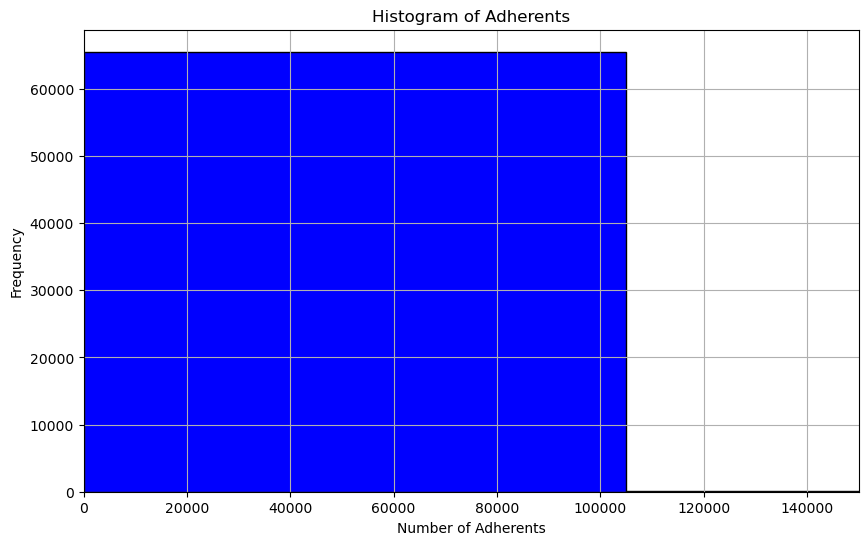

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = 'cleaned_county_data.xlsx'
df = pd.read_excel(file_path)


adherents_column = df['Adherents']


adherents_column = adherents_column.dropna()


plt.figure(figsize=(10, 6))
plt.hist(adherents_column, bins=30, color='blue', edgecolor='black')

plt.xlim(0, 150000)

plt.title('Histogram of Adherents')
plt.xlabel('Number of Adherents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd


excel_file = "processed_religion_and_election_data_county.xlsx"  
df = pd.read_excel(excel_file)


df = df[['Winner Color', 'Winning Percentage', 'Voter Percentage', 'Religiosity']]


arff_header = """@relation election_data

@attribute Winner_Color {Red, Blue}
@attribute Winning_Percentage numeric
@attribute Voter_Percentage numeric
@attribute Religiosity numeric

@data
"""


arff_data = "\n".join(",".join(map(str, row)) for row in df.values)


arff_file = "relgiong_election_county.arff"
with open(arff_file, "w") as f:
    f.write(arff_header)
    f.write(arff_data)

print(f"ARFF file '{arff_file}' created successfully!")

ARFF file 'relgiong_election_county.arff' created successfully!


In [ ]:
def convert_excel_to_arff_with_gallup_regions(input_excel, sheet_name, output_arff):
    
    df = pd.read_excel(input_excel, sheet_name=sheet_name)
    
   
    print("Original columns:", df.columns)
   
    
    df.columns = df.columns.str.strip()
    
   
    print("Columns after stripping:", df.columns)
    
   
    rename_dict = {
        "State Name": "State_Name",
        "County Name": "County_Name",
        "Group Code": "Group_Code",
        "Group Name": "Group_Name",
        "Adherents as % of Total Adherents": "Adherents_as_Percent_Total_Adherents",
        "Adherents as % of Total Population": "Adherents_as_Percent_Total_Population",
        "Total Population": "Total_Population",
        "Total Adherents": "Total_Adherents",
        "Faith Category": "Faith_Category",
    }
    
   
    if "State Name" not in df.columns:
        print("Warning: 'State Name' column not found.")
    else:
        df.rename(columns=rename_dict, inplace=True)
    
    
    print("Columns after renaming:", df.columns)
   
   
    df = df.replace({np.nan: "?"})
   
   
    gallup_region_dict = {
        "Washington": "Pacific",
        "Oregon": "Pacific",
        "California": "Pacific",
        "Alaska": "Pacific",
        "Hawaii": "Pacific",
        "Nevada": "Rockies",
        "Utah": "Rockies",
        "Idaho": "Rockies",
        "Wyoming": "Rockies",
        "Colorado": "Rockies",
        "Montana": "Rockies",
        "North Dakota": "West Central",
        "South Dakota": "West Central",
        "Nebraska": "West Central",
        "Kansas": "West Central",
        "Missouri": "West Central",
        "Iowa": "West Central",
        "Minnesota": "West Central",
        "Wisconsin": "West Central",
        "Illinois": "West Central",
        "Texas": "Southwest",
        "Oklahoma": "Southwest",
        "Arkansas": "Southwest",
        "Louisiana": "Southwest",
        "New Mexico": "Southwest",
        "Arizona": "Southwest",
        "Michigan": "East Central",
        "Indiana": "East Central",
        "Ohio": "East Central",
        "West Virginia": "East Central",
        "Kentucky": "East Central",
        "Pennsylvania": "Mid-Atlantic",
        "New Jersey": "Mid-Atlantic",
        "Delaware": "Mid-Atlantic",
        "Maryland": "Mid-Atlantic",
        "Virginia": "Mid-Atlantic",
        "Maine": "New England",
        "New Hampshire": "New England",
        "Vermont": "New England",
        "Massachusetts": "New England",
        "Rhode Island": "New England",
        "Connecticut": "New England",
        "North Carolina": "Southeast",
        "South Carolina": "Southeast",
        "Georgia": "Southeast",
        "Florida": "Southeast",
        "Alabama": "Southeast",
        "Mississippi": "Southeast",
        "Tennessee": "Southeast",
    }
   
   
    df["Gallup_Region"] = df["State_Name"].map(gallup_region_dict)
    
  
    print("Missing Gallup regions: ", df[df["Gallup_Region"] == "?"]) 
    df["Gallup_Region"].fillna("Unknown", inplace=True)
   
  
    header_lines = []
    header_lines.append("@relation religious_adherence")
    header_lines.append("")

    header_lines.append("@attribute FIPS numeric")
    header_lines.append("@attribute State_Name string")
    header_lines.append("@attribute County_Name string")
    header_lines.append("@attribute Group_Code string")
    header_lines.append("@attribute Group_Name string")
    header_lines.append("@attribute Congregations numeric")
    header_lines.append("@attribute Adherents numeric")
    header_lines.append("@attribute Adherents_as_Percent_Total_Adherents numeric")
    header_lines.append("@attribute Adherents_as_Percent_Total_Population numeric")
    header_lines.append("@attribute Total_Population numeric")
    header_lines.append("@attribute Total_Adherents numeric")
    header_lines.append("@attribute Faith_Category string")
    header_lines.append("@attribute County_Encoded numeric")
    header_lines.append("@attribute winner_color {red,blue,?}")
    header_lines.append("@attribute winning_percentage numeric")
    header_lines.append("@attribute totalvotes numeric")
    header_lines.append("@attribute voter_percentage numeric")
    header_lines.append("@attribute computed_religiosity numeric")
    header_lines.append("@attribute Gallup_Region {Pacific,Rockies,West Central,Southwest,East Central,Mid-Atlantic,New England,Southeast,Unknown}")
    header_lines.append("")
    header_lines.append("@data")
   
    arff_header = "\n".join(header_lines)
   
  
    arff_data = "\n".join(df.apply(lambda row: ",".join(map(quote_string, row)), axis=1))
   
   
    with open(output_arff, "w") as file:
        file.write(arff_header + "\n" + arff_data)
   
    print(f"Conversion complete! ARFF file saved as: {output_arff}")


In [ ]:
input_excel_file = "processed_religion_and_election_data_grouped.xlsx"
sheet_name = "Sheet1"  
output_arff_file = "processed_religion_and_election_data_grouped_gallup.arff"

convert_excel_to_arff_with_gallup_regions(input_excel_file, sheet_name, output_arff_file)

Original columns: Index(['FIPS', 'State Name', 'County Name', 'Group Code', 'Group Name',
       'Congregations', 'Adherents', 'Adherents as % of Total Adherents',
       'Adherents as % of Total Population', 'Total Population',
       'Total Adherents', 'Faith Category', 'Election Winner',
       'Winning Percentage', 'Total Votes', 'Voter Percentage',
       'Computed Religiosity'],
      dtype='object')
Columns after stripping: Index(['FIPS', 'State Name', 'County Name', 'Group Code', 'Group Name',
       'Congregations', 'Adherents', 'Adherents as % of Total Adherents',
       'Adherents as % of Total Population', 'Total Population',
       'Total Adherents', 'Faith Category', 'Election Winner',
       'Winning Percentage', 'Total Votes', 'Voter Percentage',
       'Computed Religiosity'],
      dtype='object')
Columns after renaming: Index(['FIPS', 'State_Name', 'County_Name', 'Group_Code', 'Group_Name',
       'Congregations', 'Adherents', 'Adherents_as_Percent_Total_Adherents',


C:\Users\ryanj\AppData\Local\Temp\ipykernel_33900\85020379.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Gallup_Region"].fillna("Unknown", inplace=True)


Conversion complete! ARFF file saved as: processed_religion_and_election_data_grouped_gallup.arff


In [ ]:
def add_county_size_to_arff(input_arff, output_arff):
    
    with open(input_arff, 'r') as file:
        lines = file.readlines()

  
    header_lines = []
    data_lines = []
    is_data_section = False
    for line in lines:
        if line.strip() == "@data":
            is_data_section = True
            header_lines.append(line.strip())
        elif is_data_section:
            data_lines.append(line.strip())
        else:
            header_lines.append(line.strip())

  
    df = pd.DataFrame([line.split(",") for line in data_lines])
    

    print("Columns in the data:", df.columns)

   
    columns = []
    for line in header_lines:
        if line.startswith("@attribute"):
            parts = line.split(" ")
            if len(parts) > 1 and parts[1] != "County_Size":
                columns.append(parts[1])

  
    df.columns = columns
    
  
    if "Total_Population" not in df.columns:
        print("Error: 'Total_Population' column not found!")
        return

   
    df["County_Size"] = df["Total_Population"].apply(lambda x: "small" if int(x) < 100000 else ("medium" if 100000 <= int(x) < 500000 else "large"))
    
   
    new_header = header_lines + ["@attribute County_Size {small,medium,large}"]
    new_data = "\n".join([",".join(row) for row in df.values])

   
    with open(output_arff, 'w') as file:
        file.write("\n".join(new_header) + "\n")
        file.write("\n".join(["@data"] + new_data.split("\n")))

    print(f"ARFF file with county_size saved as: {output_arff}")



input_arff = 'processed_religion_and_election_data_grouped_gallup.arff'  
output_arff = 'processed_religion_and_election_data_grouped_gallup2.arff' 

add_county_size_to_arff(input_arff, output_arff)

Columns in the data: RangeIndex(start=0, stop=21, step=1)


ValueError: Length mismatch: Expected axis has 21 elements, new values have 18 elements

In [ ]:
def convert_excel_to_arff_with_gallup_regions(input_excel, sheet_name, output_arff):

    df = pd.read_excel(input_excel, sheet_name=sheet_name)
    
  
    print("Original columns:", df.columns)
   

    df.columns = df.columns.str.strip()
    
  
    print("Columns after stripping:", df.columns)
    

    rename_dict = {
        "State Name": "State_Name",
        "County Name": "County_Name",
        "Group Code": "Group_Code",
        "Group Name": "Group_Name",
        "Adherents as % of Total Adherents": "Adherents_as_Percent_Total_Adherents",
        "Adherents as % of Total Population": "Adherents_as_Percent_Total_Population",
        "Total Population": "Total_Population",
        "Total Adherents": "Total_Adherents",
        "Faith Category": "Faith_Category",
    }
    

    if "State Name" not in df.columns:
        print("Warning: 'State Name' column not found.")
    else:
        df.rename(columns=rename_dict, inplace=True)
    
    
    print("Columns after renaming:", df.columns)
   

    df = df.replace({np.nan: "?"})
   
    gallup_region_dict = {
        "Washington": "Pacific",
        "Oregon": "Pacific",
        "California": "Pacific",
        "Alaska": "Pacific",
        "Hawaii": "Pacific",
        "Nevada": "Rockies",
        "Utah": "Rockies",
        "Idaho": "Rockies",
        "Wyoming": "Rockies",
        "Colorado": "Rockies",
        "Montana": "Rockies",
        "North Dakota": "West Central",
        "South Dakota": "West Central",
        "Nebraska": "West Central",
        "Kansas": "West Central",
        "Missouri": "West Central",
        "Iowa": "West Central",
        "Minnesota": "West Central",
        "Wisconsin": "West Central",
        "Illinois": "West Central",
        "Texas": "Southwest",
        "Oklahoma": "Southwest",
        "Arkansas": "Southwest",
        "Louisiana": "Southwest",
        "New Mexico": "Southwest",
        "Arizona": "Southwest",
        "Michigan": "East Central",
        "Indiana": "East Central",
        "Ohio": "East Central",
        "West Virginia": "East Central",
        "Kentucky": "East Central",
        "Pennsylvania": "Mid-Atlantic",
        "New Jersey": "Mid-Atlantic",
        "Delaware": "Mid-Atlantic",
        "Maryland": "Mid-Atlantic",
        "Virginia": "Mid-Atlantic",
        "Maine": "New England",
        "New Hampshire": "New England",
        "Vermont": "New England",
        "Massachusetts": "New England",
        "Rhode Island": "New England",
        "Connecticut": "New England",
        "North Carolina": "Southeast",
        "South Carolina": "Southeast",
        "Georgia": "Southeast",
        "Florida": "Southeast",
        "Alabama": "Southeast",
        "Mississippi": "Southeast",
        "Tennessee": "Southeast",
    }
   
    df["Gallup_Region"] = df["State_Name"].map(gallup_region_dict)
    

    print("Missing Gallup regions: ", df[df["Gallup_Region"] == "?"])
    df["Gallup_Region"].fillna("Unknown", inplace=True)

    df["County_Size"] = df["Total_Population"].apply(
        lambda x: "Unknown" if x == "?" else ("small" if int(x) < 100000 else ("medium" if 100000 <= int(x) < 500000 else "large"))
    )
    

    header_lines = []
    header_lines.append("@relation religious_adherence")
    header_lines.append("")

    header_lines.append("@attribute FIPS numeric")
    header_lines.append("@attribute State_Name string")
    header_lines.append("@attribute County_Name string")
    header_lines.append("@attribute Group_Code string")
    header_lines.append("@attribute Group_Name string")
    header_lines.append("@attribute Congregations numeric")
    header_lines.append("@attribute Adherents numeric")
    header_lines.append("@attribute Adherents_as_Percent_Total_Adherents numeric")
    header_lines.append("@attribute Adherents_as_Percent_Total_Population numeric")
    header_lines.append("@attribute Total_Population numeric")
    header_lines.append("@attribute Total_Adherents numeric")
    header_lines.append("@attribute Faith_Category string")
    header_lines.append("@attribute County_Encoded numeric")
    header_lines.append("@attribute winner_color {red,blue,?}")
    header_lines.append("@attribute winning_percentage numeric")
    header_lines.append("@attribute totalvotes numeric")
    header_lines.append("@attribute voter_percentage numeric")
    header_lines.append("@attribute computed_religiosity numeric")
    header_lines.append("@attribute Gallup_Region {Pacific,Rockies,West Central,Southwest,East Central,Mid-Atlantic,New England,Southeast,Unknown}")
    header_lines.append("@attribute County_Size {small,medium,large,Unknown}")
    header_lines.append("")
    header_lines.append("@data")
   
    arff_header = "\n".join(header_lines)
   
  
    arff_data = "\n".join(df.apply(lambda row: ",".join(map(quote_string, row)), axis=1))
   

    with open(output_arff, "w") as file:
        file.write(arff_header + "\n" + arff_data)
   
    print(f"Conversion complete! ARFF file saved as: {output_arff}")


In [ ]:
input_excel_file = "processed_religion_and_election_data_grouped.xlsx"
sheet_name = "Sheet1"  
output_arff_file = "new_grouped_data.arff"

convert_excel_to_arff_with_gallup_regions(input_excel_file, sheet_name, output_arff_file)

Original columns: Index(['FIPS', 'State Name', 'County Name', 'Group Code', 'Group Name',
       'Congregations', 'Adherents', 'Adherents as % of Total Adherents',
       'Adherents as % of Total Population', 'Total Population',
       'Total Adherents', 'Faith Category', 'Election Winner',
       'Winning Percentage', 'Total Votes', 'Voter Percentage',
       'Computed Religiosity'],
      dtype='object')
Columns after stripping: Index(['FIPS', 'State Name', 'County Name', 'Group Code', 'Group Name',
       'Congregations', 'Adherents', 'Adherents as % of Total Adherents',
       'Adherents as % of Total Population', 'Total Population',
       'Total Adherents', 'Faith Category', 'Election Winner',
       'Winning Percentage', 'Total Votes', 'Voter Percentage',
       'Computed Religiosity'],
      dtype='object')
Columns after renaming: Index(['FIPS', 'State_Name', 'County_Name', 'Group_Code', 'Group_Name',
       'Congregations', 'Adherents', 'Adherents_as_Percent_Total_Adherents',


C:\Users\ryanj\AppData\Local\Temp\ipykernel_33900\2272142205.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Gallup_Region"].fillna("Unknown", inplace=True)


Conversion complete! ARFF file saved as: new_grouped_data.arff
